

## **Skip-gram Model for Word2Vec**

<br>

There are two Word2Vec architectures for creating word embeddings: the Continuous Bag of Words (CBOW) architecture and the Skip Gram architecture . In this file, I obtained  word embeddings by training a skip-gram neural network model. 


The skip gram model is essentially a feedforward neural network with one hidden layer, trained to predict the context word given a target word. I trained the model by negative sampling.To train with negative sampling, the model is cast as a binary classification problem. The dataset would consist of positive and negative examples of the form:

Input | label
--| --
(target_word, word_in_its_context)       |  1 
(target_word, word_not_in_its_context)   |  0

created from the sentences in a corpus. The exact number of positive and negative examples will depend on the window size, and the balance ratio of positive:negative examples.  



The model is trained to learn to predict 1 when a word is in the context of the target word (i.e.in the window of the target word) and 0 otherwise. The model thus learns the statistics of the given corpus: the frequency with two words appear together would determine how similar they are (similarity is usually measured using cosine distance). After training, the trained hidden layer weights are the word embeddings.



### **1. Downloading the Corpus**

Our training data will be comprised of 3 documents from the Gutenberg corpus. We can find this and other corpora in nltk https://www.nltk.org/book/ch02.html

In [ ]:
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('gutenberg')
from nltk.corpus import gutenberg
austen = gutenberg.sents('austen-sense.txt') + gutenberg.sents('austen-emma.txt') + gutenberg.sents('austen-persuasion.txt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


**Sanity check:**

This training corpus contains 16498 sentences. 

In [ ]:
print(len(austen))

16498


In [ ]:
austen[0]

['[', 'Sense', 'and', 'Sensibility', 'by', 'Jane', 'Austen', '1811', ']']

### **2. Preprocessing the Training Corpus**

Performed few pre-processing techniques to remove special characters, empty strings, digits and stopwords, sentences with fewer than 3 words and put all the words into lower cases.





**Sanity check:**



In [ ]:
    stopwords = set(stopwords.words('english')) 
    stopwords  = list(stopwords)

In [ ]:
def preprocess_corpus(corpus):
    '''
    Code for preprocessing corpus 
    
    '''
  
    corpus_new = []#creating empty list

    for sen in corpus:
      sentence_new = [] 
      for wor in sen:
        if len(wor.strip()) == 0: #removing empty string
          continue
        if wor.isalpha():
            # Make sure each word is converted to Lower case when appending to the sentence 
          if wor not in stopwords:
            sentence_new.append(wor.lower())
      # append the pre-processed sentence to the Newcorpus      
      corpus_new.append(sentence_new)

    # removing sentences with fewer than 3 words 
    updated_corpus_new = []
    for l in corpus_new:
      if(len(l)>3):
        updated_corpus_new.append(l) 
    
    return updated_corpus_new
    

normalized_corpus = preprocess_corpus(austen)
print('The new length of the preprocessed output',len(normalized_corpus))

The new length of the preprocessed output 13651


<br>> We will first create a new corpus to all the sentences which are pre-processed and loop through all the sentences.
<br>>We loop through every sentence and each word in all the sentences considering alphabets only and ignoring special characters and numbers
<br>> Removed stop words, words with less than 3 in a sentence and return the updated corpus.




In [ ]:
sample = austen[:2] + austen[100:102]
preprocessed_sample = preprocess_corpus(sample)

print(len(sample), sample)
print()
print(len(preprocessed_sample), preprocessed_sample)

4 [['[', 'Sense', 'and', 'Sensibility', 'by', 'Jane', 'Austen', '1811', ']'], ['CHAPTER', '1'], ['But', ',', 'then', ',', 'if', 'Mrs', '.', 'Dashwood', 'should', 'live', 'fifteen', 'years', 'we', 'shall', 'be', 'completely', 'taken', 'in', '."'], ['"', 'Fifteen', 'years', '!']]

2 [['sense', 'sensibility', 'jane', 'austen'], ['but', 'mrs', 'dashwood', 'live', 'fifteen', 'years', 'shall', 'completely', 'taken']]


### **3. Creating the Corpus Vocabulary and Preparing the Data**


1. word2idx: a lookup table, a dictionary of (word index: word) pairs where **word index** is a unique integer assigned to every **unique word** in the corpus.
2. idx2word: a dictionary of (token: token index), a reversal of \<word2idx>. 
3. sents_as_ids: The input to the model cannot be text, rather, each word needs to be represented by a unique integer and each sentence an array of integers.




In [ ]:
# creating word2idx and idx2word dictionaries
word2idx =  {}
idx2word =  {}
 
def prepareData(normalized_corpus):

    vocabular = []

    for sen in normalized_corpus:
      for i in sen:
        vocabular.append(i)
    # to ignore repeated words we store the vocab in set 
    vocabular = list(set(vocabular))
    
    word2idx = {vocabular[i]:i for i in range(len(vocabular))}
   
    idx2word = {i:vocabular[i] for i in range(len(vocabular))}

    return word2idx,idx2word

word2idx,idx2word = prepareData(normalized_corpus)

In [ ]:

def prepareSentsAsId(normalized_corpus):
  # create a empty List 
 # Loop through all the Sentences in the Corpus and through all the words in the sentence 
 # we use word2idx is to find the index of the respective word and append this Index to the empty sentence list
    
    sentence_as_ids = []
    for sen in normalized_corpus:
      sentence_new = []#to store sentence id
      for wor in sen:
        idx = word2idx[wor]
        sentence_new.append(idx)
      
      sentence_as_ids.append(sentence_new)
     
    return sentence_as_ids

sentence_as_ids = prepareSentsAsId(normalized_corpus)
 # A Corpus which has each sentence represented as their ID's is created 

**Sanity Check**

In [ ]:
print('Number of unique words:', len(word2idx))

Number of unique words: 10180


*  The Number of Unique words in the Corpus are 10180

In [ ]:
print('\nSample word2idx: ', list(word2idx.items())[:10])


Sample word2idx:  [('assistant', 0), ('conferred', 1), ('affectionately', 2), ('unpretending', 3), ('solitarily', 4), ('electrified', 5), ('snow', 6), ('projected', 7), ('friends', 8), ('equal', 9)]


In [ ]:
print('\nSample idx2word:', list(idx2word.items())[:10])


Sample idx2word: [(0, 'assistant'), (1, 'conferred'), (2, 'affectionately'), (3, 'unpretending'), (4, 'solitarily'), (5, 'electrified'), (6, 'snow'), (7, 'projected'), (8, 'friends'), (9, 'equal')]


In [ ]:
print('\nSample sents_as_id:', prepareSentsAsId(preprocessed_sample))


Sample sents_as_id: [[6244, 5101, 9405, 1629], [9949, 8698, 8993, 3435, 7965, 5397, 9864, 9631, 4503]]


In [ ]:
VOCAB_SIZE = len(word2idx) 
EMBED_SIZE = 100 # We are creating 100D embeddings.

In [ ]:
print('Number of unique words:', len(word2idx))

Number of unique words: 10180


### **4. Generating training instances**


In this section we would generate the training examples using the keras skip-gram generator 

In [ ]:
from keras.preprocessing.sequence import skipgrams
# your code for generating training examples goes here
# Each sentence is passed to skipgrams and all the positive and negative pairs for this sentence are generated based on context and target
skip_grams = [skipgrams(sent, vocabulary_size=VOCAB_SIZE, window_size=5) for sent in sentence_as_ids]


**Sanity Check:**

To view the skip_grams for the first sentence in the training data.

In [ ]:
# check the First example 
print('Generating Positive and Negative pairs for the first sentence \n',normalized_corpus[0])
# We use the sentence Id of this particular sentence and pick all the Positive and Negative Pairs along with their labels

pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(len(pairs)):
         	print('({:s} ({:d}), {:s} ({:d})) -> {:d}'.format(
        	# the first word and its index
        	idx2word[pairs[i][0]], pairs[i][0],
        	# the second word and its index
        	idx2word[pairs[i][1]], pairs[i][1],
        	# the label
        	labels[i]))

Generating Positive and Negative pairs for the first sentence 
 ['sense', 'sensibility', 'jane', 'austen']
(jane (9405), austen (1629)) -> 1
(austen (1629), impatience (8923)) -> 0
(sense (6244), give (6390)) -> 0
(sensibility (5101), guess (1029)) -> 0
(austen (1629), sensibility (5101)) -> 1
(sense (6244), letting (4113)) -> 0
(sense (6244), sensibility (5101)) -> 1
(austen (1629), extorting (7391)) -> 0
(sensibility (5101), jane (9405)) -> 1
(jane (9405), sense (6244)) -> 1
(austen (1629), aches (2988)) -> 0
(jane (9405), wore (402)) -> 0
(sensibility (5101), austen (1629)) -> 1
(sensibility (5101), bolder (7602)) -> 0
(sense (6244), jane (9405)) -> 1
(sense (6244), undue (6519)) -> 0
(jane (9405), alert (42)) -> 0
(austen (1629), sense (6244)) -> 1
(jane (9405), lashes (9676)) -> 0
(sense (6244), austen (1629)) -> 1
(jane (9405), sensibility (5101)) -> 1
(sensibility (5101), closing (7992)) -> 0
(sensibility (5101), sense (6244)) -> 1
(austen (1629), jane (9405)) -> 1


### **5. Building the Skip-gram Neural Network Architecture**

In this section we would be building the skip-gram neural network architecture using the Keras Functional API and the Sequential model 

In [ ]:
from keras.layers import Dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import plot_model
import numpy as np

The skip-gram model is two input one output feedforward neural network with one hidden layer and this will be built over a series of steps.

####**A. The first step is to initialize and transform the first input :**

In [ ]:
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
target_word = Input((1,), dtype='int32')
#We input The Sentence Id of the sentence as target_word
#We create a Embedding matrix- which constitutes,100-dim Vector 
#We use this index of word to extract the Embedding from the Ebedding Matrix
#We pass the Input as Batches so the gradient reaches the minimum soon.
target_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='target_embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=1)(target_word)
#Reshape the 3-D tensor as a 2-D tensor using Reshape Function in Keras
target_input = Reshape((EMBED_SIZE, ))(target_embedding)

####**B.Code for the ‘context_word’ input.**

In [ ]:
# your code for the context_word goes here
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
context_word = Input((1,), dtype='int32')

# feed the words into the model using the Keras <Embedding> layer
# from whose weights we will get the word embeddings.
context_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='context_embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=1)(context_word)

#Reshape the 3-D tensor as a 2-D tensor using Reshape Function in Keras
context_input = Reshape((EMBED_SIZE, ))(context_embedding)

####**C. Merging the inputs.**


In [ ]:

merged_inputs = Dot(axes=-1, normalize=False)([target_input, context_input])
merged_inputs.shape

TensorShape([None, 1])

####**D. The Output Layer**

Pass the merged inputs (now a vector with a single number the cosine distance between the two input vectors for each word) into a sigmoid activated neuron. The output of this layer is the output of the model.



In [ ]:
# Using sigmoid activation function
from tensorflow.keras.layers import Activation
label = Activation('sigmoid')(merged_inputs)


####**E. Initializing the model:**

In [ ]:
# label is the output of step D.
model = Model(inputs=[target_word, context_word], outputs=[label])  

####**F. Compile the model** 

In [ ]:
# your code here
model.compile(loss='mean_squared_error', optimizer='rmsprop')

**Sanity check:**



In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
target_embed_layer (Embedding)  (None, 1, 100)       1018000     input_1[0][0]                    
__________________________________________________________________________________________________
context_embed_layer (Embedding) (None, 1, 100)       1018000     input_2[0][0]                    
______________________________________________________________________________________________

####**G. Plotting the model  .**

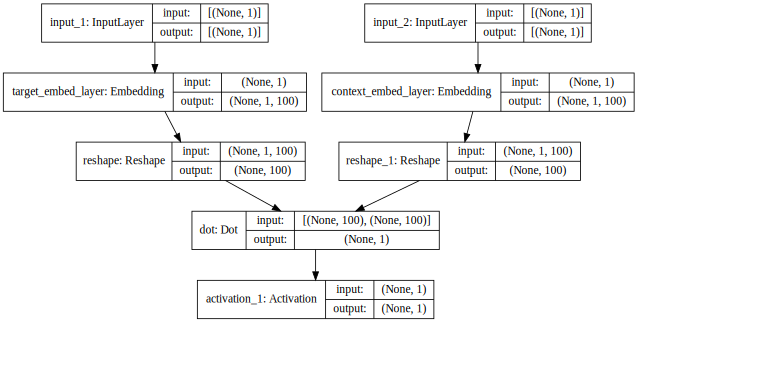

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

###**6.Training the Model**

Training the model for 5 epochs:

In [ ]:
import numpy as np

NUM_EPOCHS = 5

for epoch in range(1, NUM_EPOCHS+1):
    epoch_loss = 0
    for i, sent_examples in enumerate(skip_grams):
        target_wds = np.array([pair[0] for pair in sent_examples[0]], dtype='int32')
        context_wds = np.array([pair[1] for pair in sent_examples[0]], dtype='int32')
        labels = np.array(sent_examples[1], dtype='int32')
        X = [target_wds, context_wds]
        Y = labels
        if i % 5000 == 0: 
        	print('Processed %d sentences' %i)
        epoch_loss += model.train_on_batch(X, Y)
    print('Processed all %d sentences' %i)
    print('Epoch:', epoch, 'Loss:', epoch_loss, '\n')

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13650 sentences
Epoch: 1 Loss: 2467.770658732392 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13650 sentences
Epoch: 2 Loss: 2145.1717865858227 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13650 sentences
Epoch: 3 Loss: 2084.808251509443 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13650 sentences
Epoch: 4 Loss: 2003.7991921408102 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13650 sentences
Epoch: 5 Loss: 1918.4543599979952 



###**7. Getting the Word Embeddings**

The word embeddings are the weights of the target word embedding layer.


In [ ]:
word_embeddings = model.get_layer('target_embed_layer').get_weights()[0] 

# should return (VOCAB_SIZE, EMBED_SIZE)
print(word_embeddings.shape)

(10180, 100)


Samples of few words and their embeddings 

In [ ]:
from pandas import DataFrame

print(DataFrame(word_embeddings, index=idx2word.values()).tail(10))
df = DataFrame(word_embeddings, index=idx2word.values())

                     0         1         2   ...        97        98        99
his           -0.022273  0.029204  0.077964  ...  0.005854  0.097077  0.060768
watches       -0.008149 -0.035605  0.010716  ... -0.027675  0.050696  0.002349
scrawl        -0.013291 -0.013314  0.008680  ... -0.010698  0.016651 -0.016123
go            -0.060757 -0.003641 -0.035518  ... -0.001153  0.025051 -0.054524
conditionally -0.033802 -0.010010  0.038769  ... -0.030075  0.012936 -0.031774
named          0.000720  0.003766  0.035202  ...  0.000705  0.015846 -0.040110
slightingly   -0.033576 -0.021367  0.001884  ...  0.005102  0.001253 -0.023415
inevitable     0.002267  0.002155  0.027177  ... -0.013300  0.008322 -0.009320
declared      -0.011051 -0.050434  0.010906  ...  0.004461  0.039894 -0.028637
disdained      0.004400 -0.035706  0.039512  ... -0.036939  0.008824 -0.019910

[10 rows x 100 columns]


###**8.  Measuring Similarity Between Word Pairs**



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(word_embeddings)

# should print(VOCAB_SIZE, VOCAB_SIZE)
print(similarity_matrix.shape)

(10180, 10180)


###**9. Exploring and Visualizing  Word Embeddings using t-SNE**

**Sanity check: Getting the 5 most similar words to the search items in the list below**

search_terms = ['family', 'love', 'equality', 'wisdom', 'justice',  'humour', 'rejection']




In [ ]:
search_terms = ['family', 'love', 'equality', 'wisdom', 'justice', 'humour', 'rejection']

# write code to get the 5 words most similar to the words in search_terms
#we are first going to extract the word from the search_terms based on Index 
# then extract all the similar words which are to be similar to all the "given search index" and sort the similarity vector accoording to its values

for idx in range(len(search_terms)):
  idx = idx
  similar_words=[]

  for i in list(np.argsort(similarity_matrix[word2idx[search_terms[idx]]])[-6:-1]):
    similar_words.append(idx2word[i])   
  print('5 similar words for {}'.format(search_terms[idx]),similar_words)

idx = 2
similar_words  = [idx2word[i] 
                  for i in list(np.argsort(similarity_matrix[word2idx[search_terms[idx]]])[-6:-1])]
print('5 similar words for {}'.format(search_terms[idx]),similar_words)

#We then use the 5 index's in the idx2word  to extract the 5 similar words

5 similar words for family ['russell', 'way', 'children', 'musgrove', 'elliot']
5 similar words for love ['deal', 'elliot', 'musgrove', 'harriet', 'account']
5 similar words for equality ['reside', 'forbear', 'gifted', 'depressed', 'ungrateful']
5 similar words for wisdom ['bluntness', 'clownish', 'warfare', 'sloop', 'hated']
5 similar words for justice ['think', 'circumstances', 'girl', 'world', 'wrong']
5 similar words for humour ['lived', 'worse', 'tenderness', 'marry', 'recollect']
5 similar words for rejection ['exactness', 'hamilton', 'prosperously', 'ordained', 'proves']
5 similar words for equality ['reside', 'forbear', 'gifted', 'depressed', 'ungrateful']


In [ ]:
search_terms = ['think', 'thought', 'mr', 'friend', 'love', 'disdain']

#we are first going to extract the word from the search_terms based on Index 
# then extract all the similar words which are to be similar to all the "given search index" and then sort the similarity vector accordingly to its values
for idx in range(len(search_terms)):
  idx = idx
  similar_words=[]
  for i in list(np.argsort(similarity_matrix[word2idx[search_terms[idx]]])[-6:-1]):
    similar_words.append(idx2word[i])   
  print('5 similar words for {}'.format(search_terms[idx]),similar_words)

idx = 2
similar_words  = [idx2word[i] 
                  for i in list(np.argsort(similarity_matrix[word2idx[search_terms[idx]]])[-6:-1])]
print('5 similar words for {}'.format(search_terms[idx]),similar_words)

#We  use the 5 index's in the idx2word  to extract the 5 similar words

5 similar words for think ['woman', 'world', 'jane', 'well', 'know']
5 similar words for thought ['russell', 'coming', 'mary', 'heard', 'anne']
5 similar words for mr ['elliot', 'robert', 'jane', 'elton', 'knightley']
5 similar words for friend ['heard', 'anne', 'harriet', 'russell', 'elliot']
5 similar words for love ['deal', 'elliot', 'musgrove', 'harriet', 'account']
5 similar words for disdain ['largest', 'obviate', 'war', 'atoned', 'passes']
5 similar words for mr ['elliot', 'robert', 'jane', 'elton', 'knightley']


**B. Plotting the words in the dictionary above using t-SNE** 















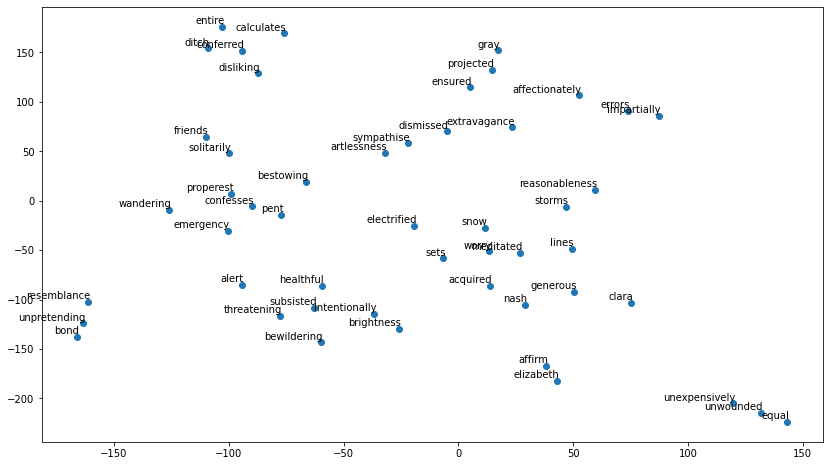

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50 

T = tsne.fit_transform(word_embeddings[:plot_only, :])
labels = [idx2word[i+1] for i in range(plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')                      	                        
